In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import chex
from flyjax.agent.model import base_agent
from flyjax.simulation.simulate import simulate_experiment_jit, simulate_dataset_jit, simulate_dataset_jit_different_params
from flyjax.simulation.parse import parse_reward_matrix
from flyjax.fitting.train import multi_start_train, evaluate_model
from flyjax.fitting.joint import multi_start_joint_train, evaluate_joint_model
from flyjax.fitting.hierarchical import multi_start_hierarchical_train, evaluate_hierarchical_model
from flyjax.utils.plotting import plot_experiment_data

In [2]:
# 0. Set up random number generator
rng_key = jax.random.PRNGKey(0)
    
# 1. Define "true" parameters
true_params = jnp.array([2.0, -1.0, 1.0, 0.1])
print("True params:", true_params)

True params: [ 2.  -1.   1.   0.1]


# Test the simulation code

In [3]:
# Create a small reward matrix for testing.
test_reward_matrix = jnp.array([[0.33, 0.67]] * 10)  # 10 trials

# Test without baiting.
choices_no_bait, rewards_no_bait = simulate_experiment_jit(true_params, test_reward_matrix, base_agent, rng_key, baiting=False)
print("No baiting:", choices_no_bait, rewards_no_bait)

# Test with baiting.
choices_bait, rewards_bait = simulate_experiment_jit(true_params, test_reward_matrix, base_agent, rng_key, baiting=True)
print("With baiting:", choices_bait, rewards_bait)

# Test the dataset simulation.
reward_matrices = [test_reward_matrix] * 3
experiments = simulate_dataset_jit(true_params, jnp.stack(reward_matrices), base_agent, rng_key, baiting=True)
print("Simulated dataset:", experiments)

# Test the dataset simulation with different parameters.
params_stack = jnp.stack([true_params + jax.random.normal(rng_key, shape=true_params.shape) for _ in range(3)])
experiments_diff_params = simulate_dataset_jit_different_params(params_stack, jnp.stack(reward_matrices), base_agent, rng_key, baiting=True)
print("Simulated dataset with different parameters:", experiments_diff_params)

No baiting: [1 1 1 1 1 1 0 0 0 0] [1 1 1 1 1 1 1 1 0 0]
With baiting: [1 1 1 1 0 0 1 1 1 1] [1 1 1 1 1 1 1 1 1 0]
Simulated dataset: (Array([[1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 1, 1, 1, 1]], dtype=int32), Array([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 0, 1]], dtype=int32, weak_type=True))
Simulated dataset with different parameters: (Array([[1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 1, 1, 1, 1]], dtype=int32), Array([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 0, 1]], dtype=int32, weak_type=True))


# Generate a dataset with the simulation code and fit a model to it. The model should be able to predict the parameters of the simulation code.

In [4]:
# --- Set true parameters for simulation ---
# params = [alpha_learn_logit, alpha_forget_logit, kappa_reward, kappa_omission]
true_params = jnp.array([2.0, -1.0, 1.0, 0.1])
print("True parameters:", true_params)

# --- Simulate a dataset ---
# Define the reward probabilities for each experiment.
n_replicates = 8
reward_matrices = [
    parse_reward_matrix("[0.0,0.0]x30;[0.33,0.17]x40;[0.33,0.67]x40;[0.17,0.33]x40;[0.89,0.11]x40;[0.33,0.17]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.33,0.17]x40;[0.33,0.67]x40;[0.89,0.11]x40;[0.67,0.33]x40;[0.17,0.33]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.33,0.17]x40;[0.11,0.89]x40;[0.17,0.33]x40;[0.67,0.33]x40;[0.33,0.17]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.33,0.17]x40;[0.11,0.89]x40;[0.67,0.33]x40;[0.89,0.11]x40;[0.17,0.33]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.67,0.33]x40;[0.17,0.33]x40;[0.33,0.67]x40;[0.89,0.11]x40;[0.67,0.33]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.67,0.33]x40;[0.17,0.33]x40;[0.89,0.11]x40;[0.33,0.17]x40;[0.33,0.67]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.67,0.33]x40;[0.11,0.89]x40;[0.33,0.17]x40;[0.89,0.11]x40;[0.33,0.67]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.67,0.33]x40;[0.11,0.89]x40;[0.33,0.67]x40;[0.89,0.11]x40;[0.67,0.33]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.89,0.11]x40;[0.17,0.33]x40;[0.11,0.89]x40;[0.67,0.33]x40;[0.89,0.11]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.89,0.11]x40;[0.17,0.33]x40;[0.67,0.33]x40;[0.33,0.17]x40;[0.11,0.89]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.89,0.11]x40;[0.33,0.67]x40;[0.33,0.17]x40;[0.67,0.33]x40;[0.11,0.89]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.89,0.11]x40;[0.33,0.67]x40;[0.11,0.89]x40;[0.33,0.17]x40;[0.89,0.11]x40")
]*n_replicates

rng_key = jax.random.PRNGKey(0)
rng_key, subkey = jax.random.split(rng_key)
choices, rewards = simulate_dataset_jit(true_params, jnp.stack(reward_matrices), base_agent, subkey, baiting=True)
n_experiments = len(reward_matrices)
# convert to experiment data format
experiments = [(choices[i], rewards[i]) for i in range(n_experiments)]

True parameters: [ 2.  -1.   1.   0.1]


/Users/neurorishika/Projects/Janelia/flYJAX/flyjax/utils/plotting.py:26: RuntimeWarning: invalid value encountered in divide
  reward_ratio = np.where(reward_0 + reward_1 > 0, reward_1 / (reward_0 + reward_1), 0.5)


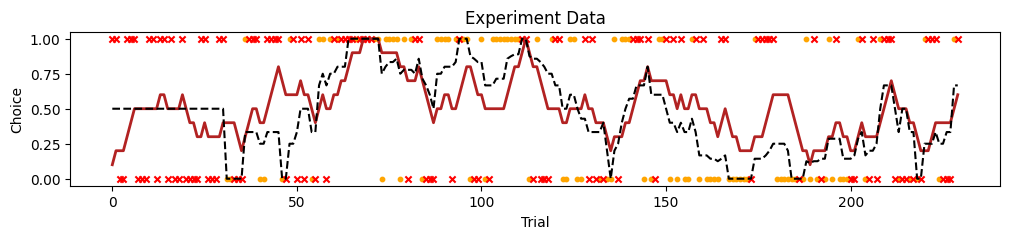

In [5]:
# Plot the first experiment.
plot_experiment_data(experiments[0])

In [ ]:
# --- Fit the model to the simulated data ---
def sample_init_params() -> chex.Array:
    # params = [alpha_learn_logit, alpha_forget_logit, kappa_reward, kappa_omission]
    # You can adjust the scale to suit your model.
    return jnp.array(np.random.randn(4))  # standard normal initialization

# Run multi-start training with, say, 5 random initializations.
best_params, training_losses = multi_start_train(
    n_restarts=5,
    init_param_sampler=sample_init_params,
    agent=base_agent,
    training_experiments=experiments,
    learning_rate=0.01,
    num_steps=1000,
    verbose=True,
    progress_bar=True,
    early_stopping={"patience": 100, "min_delta": 1e-4}
)

print("\nBest recovered parameters from training:", best_params)


--- Restart 1/5 ---


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
# Lets generate some experiments with some modified parameters to test the multi group training

# --- Set perturbed parameters for simulation ---
# params = [alpha_learn_logit, alpha_forget_logit, kappa_reward, kappa_omission]
perturbed_params = jnp.array([2.5, 0.0, 0.8, 0.0])
print("Perturbed parameters:", perturbed_params)

# --- Simulate a dataset with perturbed parameters ---
rng_key, subkey = jax.random.split(rng_key)
perturbed_choices, perturbed_rewards = simulate_dataset_jit(perturbed_params, jnp.stack(reward_matrices), base_agent, subkey, baiting=True)
n_perturbed_experiments = len(reward_matrices)
# convert to experiment data format
perturbed_experiments = [(perturbed_choices[i], perturbed_rewards[i]) for i in range(n_perturbed_experiments)]

Perturbed parameters: [2.5 0.  0.8 0. ]


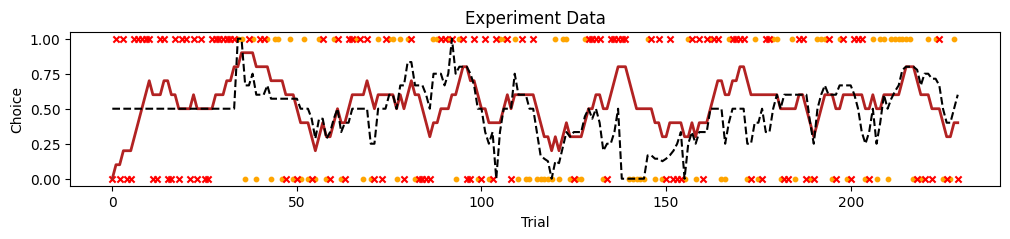

In [7]:
# Plot the first experiment.
plot_experiment_data(perturbed_experiments[5])

In [ ]:
# Define samplers for initial parameters.
def sample_init_theta() -> chex.Array:
    # For instance, sample control parameters from a standard normal distribution.
    return jnp.array(np.random.randn(4))

def sample_init_delta() -> chex.Array:
    # Sample delta from a small-variance normal distribution.
    return jnp.array(0.1 * np.random.randn(4))

# Run multi-start joint training (e.g., with 5 restarts).
best_theta, best_delta, joint_losses = multi_start_joint_train(
    n_restarts=5,
    init_theta_sampler=sample_init_theta,
    init_delta_sampler=sample_init_delta,
    agent=base_agent,
    experiments_control=experiments,
    experiments_exp=perturbed_experiments,
    n_params=4,
    learning_rate=0.01,
    num_steps=1000,
    delta_penalty_sigma=1.0,
    verbose=True
)

print("\nBest recovered control parameters:", best_theta)
print("Best recovered delta (experimental shift):", best_delta)


--- Joint Restart 1/5 ---


Joint Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Joint NLL: 30713.7891
Step  100, Joint NLL: 29189.2051
Step  200, Joint NLL: 29087.3281
Step  300, Joint NLL: 29061.5156
Step  400, Joint NLL: 29054.0801
Step  500, Joint NLL: 29051.1289
Step  600, Joint NLL: 29049.8496
Step  700, Joint NLL: 29049.2637
Step  800, Joint NLL: 29048.9902
Step  900, Joint NLL: 29048.8477
Restart 1 final Joint NLL: 29048.7852

--- Joint Restart 2/5 ---


Joint Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Joint NLL: 32753.2832
Step  100, Joint NLL: 30572.1504
Step  200, Joint NLL: 30016.3262
Step  300, Joint NLL: 29541.3691
Step  400, Joint NLL: 29260.5195
Step  500, Joint NLL: 29129.8301
Step  600, Joint NLL: 29086.9785
Step  700, Joint NLL: 29070.6230
Step  800, Joint NLL: 29062.3887
Step  900, Joint NLL: 29057.6621
Restart 2 final Joint NLL: 29054.7734

--- Joint Restart 3/5 ---


Joint Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Joint NLL: 32575.2832
Step  100, Joint NLL: 30034.4551
Step  200, Joint NLL: 29497.9883
Step  300, Joint NLL: 29215.5332
Step  400, Joint NLL: 29110.0000
Step  500, Joint NLL: 29078.9648
Step  600, Joint NLL: 29066.4551
Step  700, Joint NLL: 29059.7930
Step  800, Joint NLL: 29055.8828
Step  900, Joint NLL: 29053.4805
Restart 3 final Joint NLL: 29051.9551

--- Joint Restart 4/5 ---


Joint Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Joint NLL: 30507.4668
Step  100, Joint NLL: 29208.0488
Step  200, Joint NLL: 29085.8301
Step  300, Joint NLL: 29059.4688
Step  400, Joint NLL: 29053.2461
Step  500, Joint NLL: 29050.9648
Step  600, Joint NLL: 29049.9062
Step  700, Joint NLL: 29049.3730
Step  800, Joint NLL: 29049.0820
Step  900, Joint NLL: 29048.9180
Restart 4 final Joint NLL: 29048.8359

--- Joint Restart 5/5 ---


Joint Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Joint NLL: 30358.8047
Step  100, Joint NLL: 29122.6758
Step  200, Joint NLL: 29061.1562
Step  300, Joint NLL: 29050.9082
Step  400, Joint NLL: 29049.2520
Step  500, Joint NLL: 29048.9277
Step  600, Joint NLL: 29048.8223
Step  700, Joint NLL: 29048.7695
Step  800, Joint NLL: 29048.7441
Step  900, Joint NLL: 29048.7285
Restart 5 final Joint NLL: 29048.7207

Best Joint NLL: 29048.7207

Best recovered control parameters: [ 1.997179   -0.87878704  1.0085219   0.07067695]
Best recovered delta (experimental shift): [ 1.4246544   0.8656435  -0.19560982 -0.06934387]


NameError: name 'evaluate_joint_model' is not defined

In [11]:
print("True Control Parameters:", true_params)
print("Control Parameters:", best_theta)
print("True Experimental Parameters:", perturbed_params)
print("Experimental Parameters:", best_theta + best_delta)


True Control Parameters: [ 2.  -1.   1.   0.1]
Control Parameters: [ 1.997179   -0.87878704  1.0085219   0.07067695]
True Experimental Parameters: [2.5 0.  0.8 0. ]
Experimental Parameters: [ 3.4218335e+00 -1.3143539e-02  8.1291211e-01  1.3330802e-03]


In [13]:
# Evaluate the joint model on the two groups.
nll_control, nll_exp, joint_nll = evaluate_joint_model(
    best_theta, best_delta, base_agent, experiments, perturbed_experiments, delta_penalty_sigma=1.0
)
print(f"\nEvaluation:")
print(f"  Control NLL: {nll_control:.4f}")
print(f"  Experimental NLL: {nll_exp:.4f}")
print(f"  Joint NLL: {joint_nll:.4f}")
print(f"  Delta penalty: {joint_nll - nll_control - nll_exp:.4f}")


Evaluation:
  Control NLL: 14428.5566
  Experimental NLL: 14618.7539
  Joint NLL: 29048.7207
  Delta penalty: 1.4102


In [8]:
# --- Multi subject training ---

# build a dataset with multiple subjects assuming each subject has the different parameters sampled from a normal distribution
n_subjects = len(reward_matrices)
subject_params = []
for _ in range(n_subjects):
    rng_key, subkey = jax.random.split(rng_key)
    subject_params.append(true_params + 0.2*jax.random.normal(rng_key, shape=true_params.shape))

# Simulate the dataset for each subject.
rng_key, subkey = jax.random.split(rng_key)
choices, rewards = simulate_dataset_jit_different_params(jnp.stack(subject_params), jnp.stack(reward_matrices), base_agent, rng_key, baiting=True)
# Assuming 'choices' and 'rewards' are produced by simulate_dataset_jit_different_params
n_experiments = choices.shape[0]
subject_experiments = [[(np.array(choices[i]), np.array(rewards[i]))] for i in range(n_experiments)] # this is done because we assume each subject has only one experiment


In [9]:
print("Number of subjects:", n_subjects)
print("True parameters for the subjects:", subject_params)

# Define samplers for initial parameters.
def sample_init_theta_pop() -> chex.Array:
    # For instance, sample population-level parameters from a standard normal distribution.
    return jnp.array(np.random.randn(4))

def sample_init_theta_subjects() -> chex.Array:
    # Sample subject-specific parameters from a standard normal distribution.
    return jnp.array(np.random.randn(n_subjects, 4))

# Run multi-start hierarchical training (e.g., with 5 restarts).
best_theta_pop, best_theta_subjects, hierarchical_losses = multi_start_hierarchical_train(
    n_restarts=5,
    init_theta_pop_sampler=sample_init_theta_pop,
    init_theta_subjects_sampler=sample_init_theta_subjects,
    agent=base_agent,
    experiments_by_subject=subject_experiments,
    n_params=4,
    learning_rate=0.01,
    num_steps=1000,
    sigma_prior=1.0,
    verbose=True
)

print("\nBest recovered population-level parameters:", best_theta_pop)
print("Best recovered subject-specific parameters:", best_theta_subjects)

Number of subjects: 96
True parameters for the subjects: [Array([ 1.7074176 , -1.0703456 ,  0.967721  , -0.05662847], dtype=float32), Array([ 1.6867114 , -1.1560814 ,  0.7477006 ,  0.30806813], dtype=float32), Array([ 1.8532976 , -0.73311317,  1.3035392 , -0.07623582], dtype=float32), Array([ 2.040987  , -0.80223036,  0.9972477 ,  0.24306133], dtype=float32), Array([ 1.9684147 , -1.0992843 ,  0.9900699 ,  0.32679555], dtype=float32), Array([ 1.9831579 , -0.7629758 ,  1.1385388 , -0.10341506], dtype=float32), Array([ 1.936808  , -0.83503234,  1.4716271 ,  0.24968287], dtype=float32), Array([ 1.9686192 , -1.0337689 ,  1.232622  , -0.00510482], dtype=float32), Array([ 2.2289677 , -1.3602388 ,  1.1522466 ,  0.18426695], dtype=float32), Array([ 1.9596618 , -0.7156086 ,  1.1662055 ,  0.22523156], dtype=float32), Array([ 1.8680817 , -1.3863366 ,  1.3960499 ,  0.17726168], dtype=float32), Array([ 1.9549723 , -1.064041  ,  1.0234969 , -0.07199951], dtype=float32), Array([ 2.4089468, -0.6001693,

Hierarchical Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 16672.6152
Step  100, Hierarchical NLL: 15000.3633
Step  200, Hierarchical NLL: 14607.2305
Step  300, Hierarchical NLL: 14440.0234
Step  400, Hierarchical NLL: 14365.5625
Step  500, Hierarchical NLL: 14339.8848
Step  600, Hierarchical NLL: 14329.2725
Step  700, Hierarchical NLL: 14324.1904
Step  800, Hierarchical NLL: 14321.4102
Step  900, Hierarchical NLL: 14319.7852
Restart 1 final Hierarchical NLL: 14318.8174

--- Hierarchical Restart 2/5 ---


Hierarchical Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 16862.5469
Step  100, Hierarchical NLL: 14977.0830
Step  200, Hierarchical NLL: 14566.2832
Step  300, Hierarchical NLL: 14430.8564
Step  400, Hierarchical NLL: 14374.0156
Step  500, Hierarchical NLL: 14346.7471
Step  600, Hierarchical NLL: 14332.2539
Step  700, Hierarchical NLL: 14324.9316
Step  800, Hierarchical NLL: 14321.1191
Step  900, Hierarchical NLL: 14319.4199
Restart 2 final Hierarchical NLL: 14318.5215

--- Hierarchical Restart 3/5 ---


Hierarchical Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 16850.5430
Step  100, Hierarchical NLL: 15034.0938
Step  200, Hierarchical NLL: 14596.0107
Step  300, Hierarchical NLL: 14449.3027
Step  400, Hierarchical NLL: 14389.5811
Step  500, Hierarchical NLL: 14357.0811
Step  600, Hierarchical NLL: 14339.1719
Step  700, Hierarchical NLL: 14329.1299
Step  800, Hierarchical NLL: 14323.7949
Step  900, Hierarchical NLL: 14321.0479
Restart 3 final Hierarchical NLL: 14319.5498

--- Hierarchical Restart 4/5 ---


Hierarchical Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 16890.8027
Step  100, Hierarchical NLL: 15112.6045
Step  200, Hierarchical NLL: 14622.5371
Step  300, Hierarchical NLL: 14442.9326
Step  400, Hierarchical NLL: 14380.1582
Step  500, Hierarchical NLL: 14350.0400
Step  600, Hierarchical NLL: 14335.8271
Step  700, Hierarchical NLL: 14328.8018
Step  800, Hierarchical NLL: 14324.4922
Step  900, Hierarchical NLL: 14321.7178
Restart 4 final Hierarchical NLL: 14320.0684

--- Hierarchical Restart 5/5 ---


Hierarchical Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 16356.7441
Step  100, Hierarchical NLL: 14820.7773
Step  200, Hierarchical NLL: 14497.1484
Step  300, Hierarchical NLL: 14389.1992
Step  400, Hierarchical NLL: 14351.2578
Step  500, Hierarchical NLL: 14335.5947
Step  600, Hierarchical NLL: 14327.5918
Step  700, Hierarchical NLL: 14323.4697
Step  800, Hierarchical NLL: 14321.1182
Step  900, Hierarchical NLL: 14319.6289
Restart 5 final Hierarchical NLL: 14318.6855

Best Hierarchical NLL: 14318.5215

Best recovered population-level parameters: [ 1.3085225  -0.6545792   1.0201273   0.01030146]
Best recovered subject-specific parameters: [[ 1.56566739e+00 -4.45390910e-01  1.03230155e+00  2.73849368e-01]
 [ 1.42534530e+00 -4.39507633e-01  9.85161245e-01  4.96802062e-01]
 [ 1.29115546e+00 -6.26167893e-01  9.71843421e-01 -3.13410372e-01]
 [ 1.46677709e+00 -3.05551738e-01  9.54307854e-01 -1.51078880e-01]
 [ 4.86055493e-01 -8.69817317e-01  1.03220952e+00  6.26218915e-02]
 [ 1.10078788e+00 -7.26818383e-01  7.85696089e

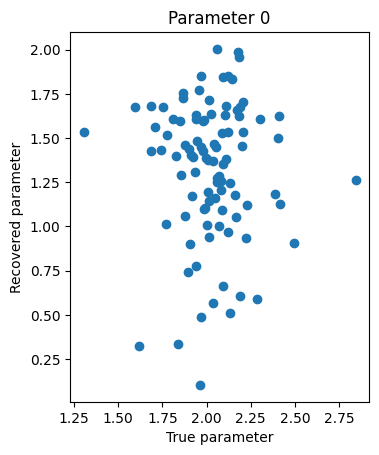

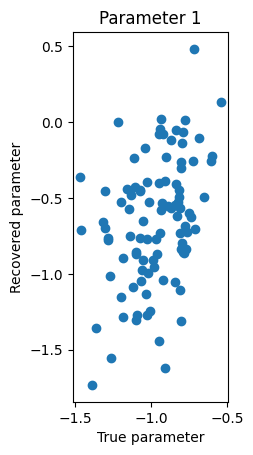

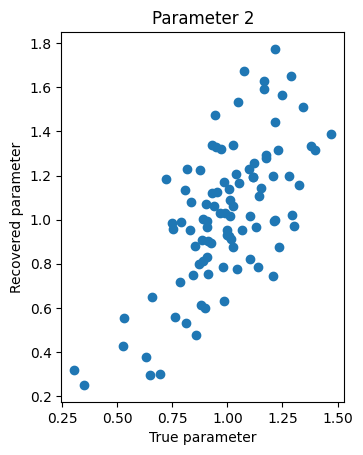

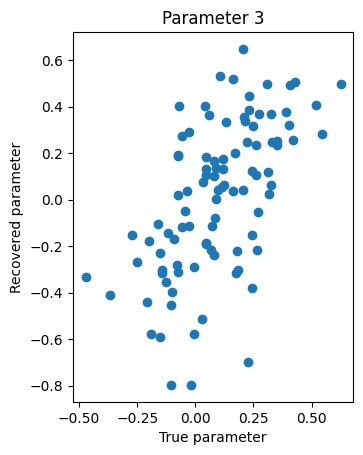

In [11]:
import matplotlib.pyplot as plt
for i in range(4):
    plt.scatter(jnp.array(subject_params)[:,i], best_theta_subjects[:,i])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("True parameter")
    plt.ylabel("Recovered parameter")
    plt.title(f"Parameter {i}")
    plt.show()